In [70]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

import keras
import matplotlib.cm as cm

In [71]:
levels = ['Normal', 'Tuberculosis']
path = "../Data/TB_Chest_Radiography_Database"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'Tuberculosis_result'])

data['path'] = path + '/' + data['image_file']
data['Tuberculosis_result'] = data['Tuberculosis_result'].map({'Normal': 'Negative', 'Tuberculosis': 'Positive'})
samples = 4200

data.head()

,image_file,Tuberculosis_result,path
0,Normal/Normal-1.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...
1,Normal/Normal-10.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...
2,Normal/Normal-100.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...
3,Normal/Normal-1000.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...
4,Normal/Normal-1001.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...


In [72]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 4200


In [73]:
df = pd.DataFrame()
df['Tuberculosis_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['Tuberculosis_result'] == 'Positive']), len(data[data['Tuberculosis_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'Tuberculosis_result', y = 'Count', 
    color = "Tuberculosis_result", text_auto='', width = 600, 
    color_discrete_sequence = ["orange", "purple"],
    template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

In [74]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

,image_file,Tuberculosis_result,path,image
0,Normal/Normal-1.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...,"[[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], ..."
1,Normal/Normal-10.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...,"[[[211, 211, 211], [172, 172, 172], [151, 151,..."
2,Normal/Normal-100.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...,"[[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ..."
3,Normal/Normal-1000.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...,"[[[246, 246, 246], [231, 231, 231], [222, 222,..."
4,Normal/Normal-1001.png,Negative,../Data/TB_Chest_Radiography_Database/Normal/N...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


**Exploratory Data Analysis**

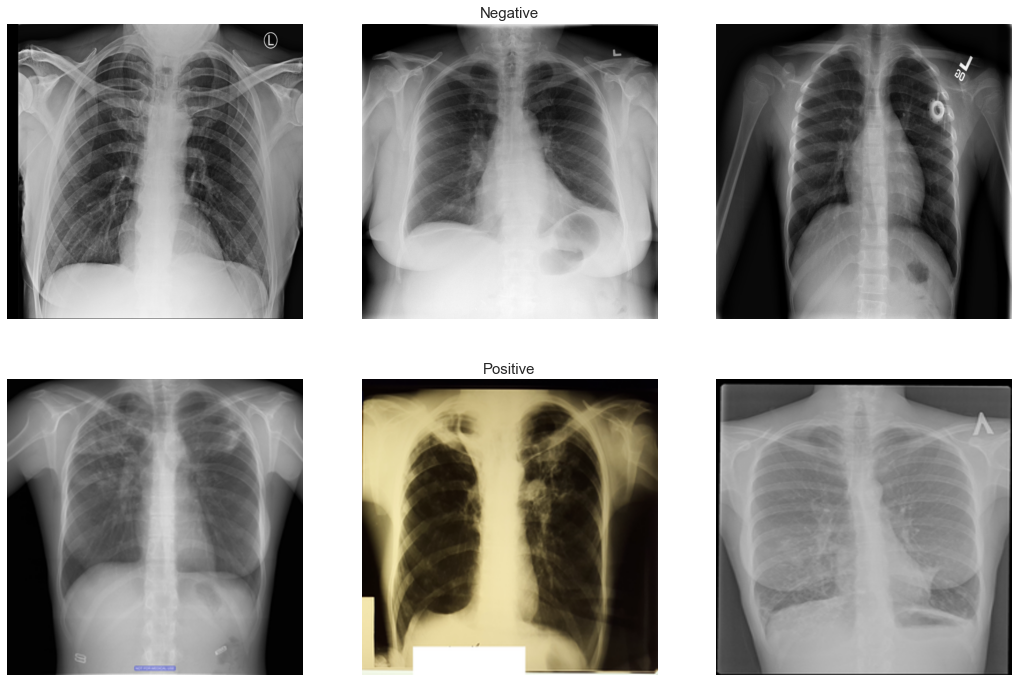

In [75]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['Tuberculosis_result']).groupby('Tuberculosis_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

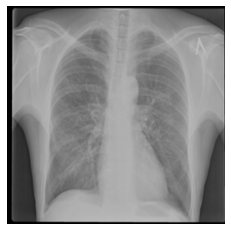

In [76]:
plt.figure()
image = cv2.imread("../Data/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-18.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [77]:

print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (512, 512, 3)
Image Height: 512
Image Width: 512
Image Dimension: 3
Image Size: 768kb
Image Data Type: uint8
Maximum RGB value of the image: 200
Minimum RGB value of the image: 0


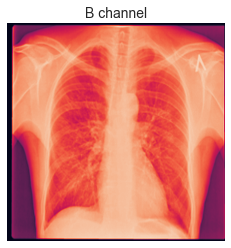

In [78]:
plt.title('B channel', fontsize = 14)
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

In [79]:
all_tuberculosis = []
all_normal = []

all_normal.extend(glob(os.path.join(path, "Normal/*.png")))
all_tuberculosis.extend(glob(os.path.join(path, "Tuberculosis/*.png")))

random.shuffle(all_normal)
random.shuffle(all_tuberculosis)

images = all_normal[:50] + all_tuberculosis[:50]

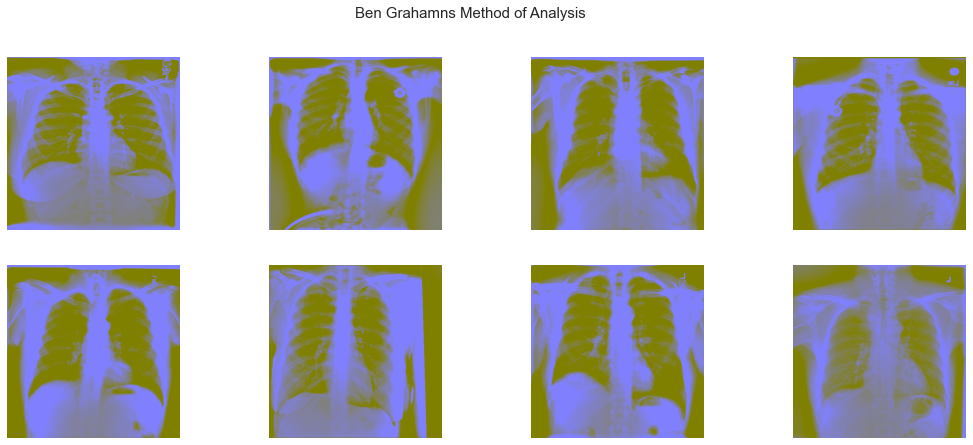

In [80]:
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

In [81]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

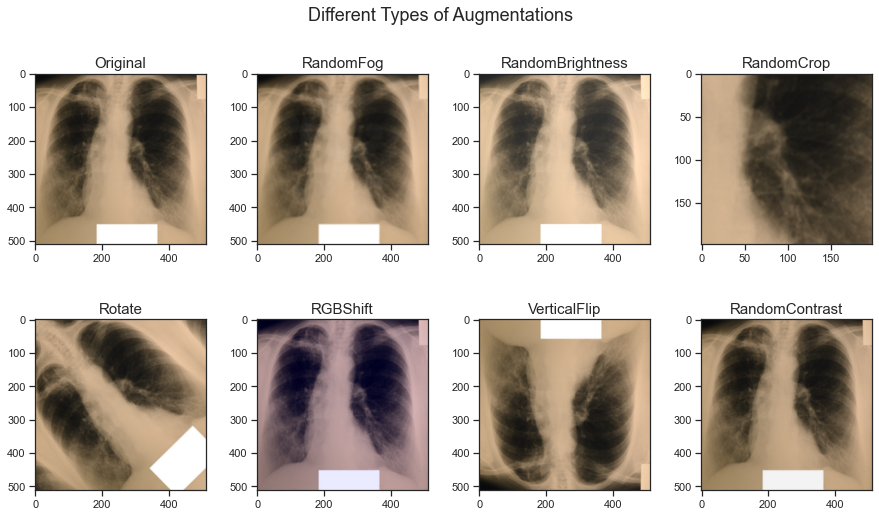

In [82]:
chosen_image = cv2.imread("../Data/TB_Chest_Radiography_Database/tuberculosis/tuberculosis-1.png")

albumentation_list = [A.RandomFog(p = 1), A.RandomBrightness(p = 1),
    A.RandomCrop(p = 1,height = 199, width = 199), A.Rotate(p = 1, limit = 90),
    A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomContrast(limit = 0.5, p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

**Image Value Distribution**

In [83]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','Tuberculosis_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

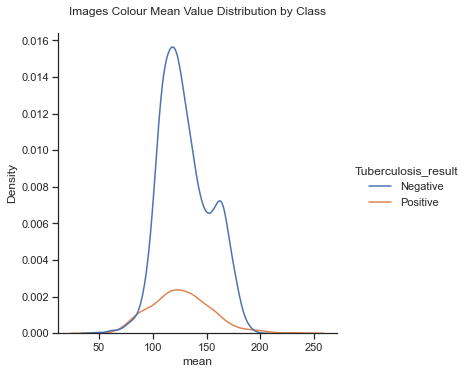

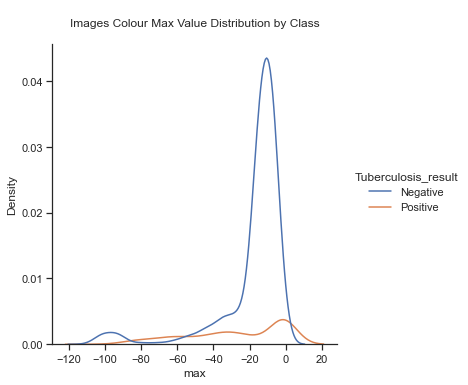

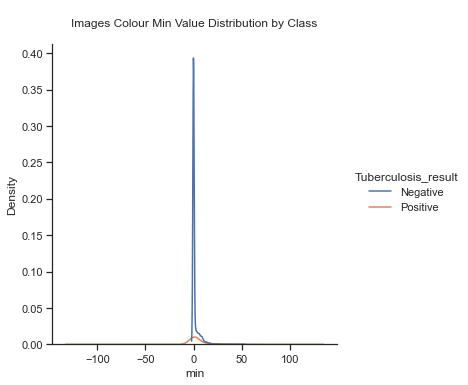

In [84]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'Tuberculosis_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'Tuberculosis_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'Tuberculosis_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

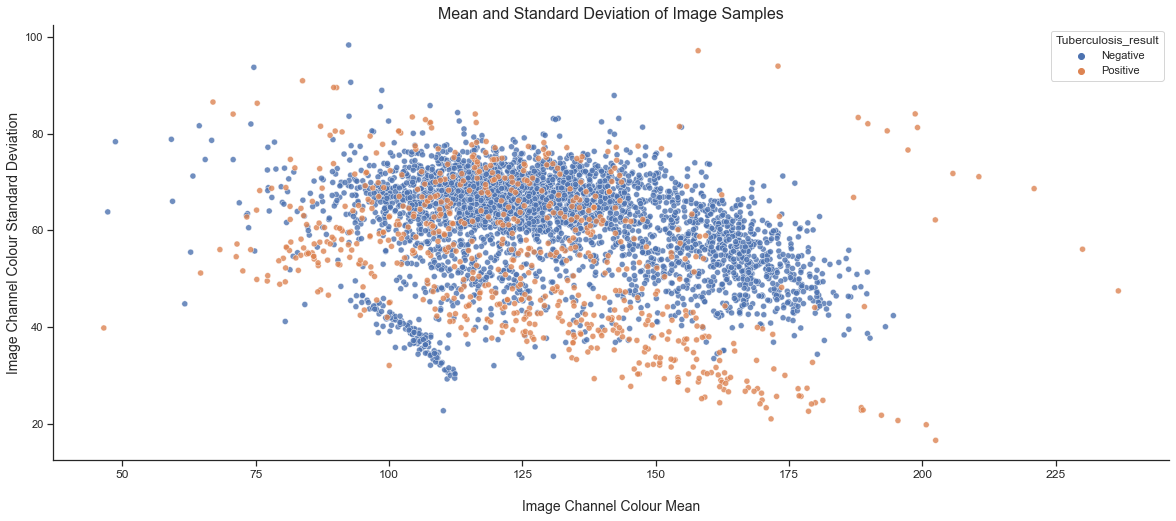

In [85]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'Tuberculosis_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

<Figure size 720x576 with 0 Axes>

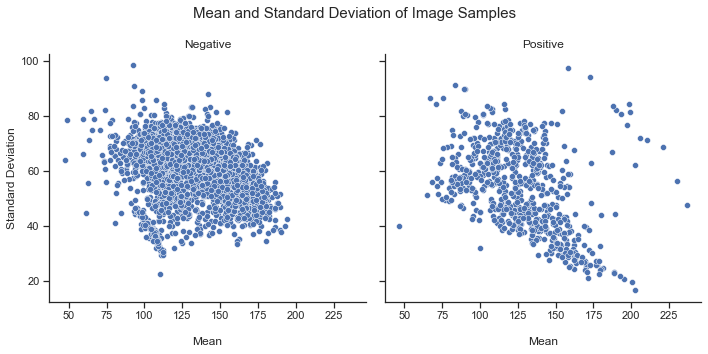

In [86]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "Tuberculosis_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

**Data Modeling**

*Train test*

In [87]:
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['Tuberculosis_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [88]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(3024, 70, 70, 3) (840, 70, 70, 3) (336, 70, 70, 3) (3024,) (840,) (336,)


*CNN MODEL*

In [89]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
    metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 34, 34, 128)      0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 34, 34, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 64)       

In [90]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
12/12 [==============================] - 22s 2s/step - loss: 0.4938 - accuracy: 0.7771 - val_loss: 0.4990 - val_accuracy: 0.8065
Epoch 2/50
12/12 [==============================] - 20s 2s/step - loss: 0.3993 - accuracy: 0.8353 - val_loss: 0.4004 - val_accuracy: 0.8065
Epoch 3/50
12/12 [==============================] - 20s 2s/step - loss: 0.3233 - accuracy: 0.8499 - val_loss: 0.3266 - val_accuracy: 0.8571
Epoch 4/50
12/12 [==============================] - 20s 2s/step - loss: 0.2443 - accuracy: 0.8925 - val_loss: 0.2185 - val_accuracy: 0.9286
Epoch 5/50
12/12 [==============================] - 20s 2s/step - loss: 0.2012 - accuracy: 0.9177 - val_loss: 0.2017 - val_accuracy: 0.8988
Epoch 6/50
12/12 [==============================] - 20s 2s/step - loss: 0.1764 - accuracy: 0.9335 - val_loss: 0.1851 - val_accuracy: 0.9048
Epoch 7/50
12/12 [==============================] - 22s 2s/step - loss: 0.1873 - accuracy: 0.9309 - val_loss: 0.1735 - val_accuracy: 0.9137
Epoch 8/50
12/12 [==

In [91]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

In [92]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    print("\n-----------------------------{}-----------------------------\n".format(name)) 
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2526
           1       0.98      0.87      0.92       498

    accuracy                           0.97      3024
   macro avg       0.97      0.93      0.95      3024
weighted avg       0.97      0.97      0.97      3024

--------------------------------------------------------------------------
Recall on Train Data:  0.8655
Specificity on Train Data:  0.9956
Accuracy on Train Data:  0.9742
Precision on Train Data:  0.9751
F1 Score on Train Data:  0.917
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.95      0.86      0.90        65

    accuracy                 

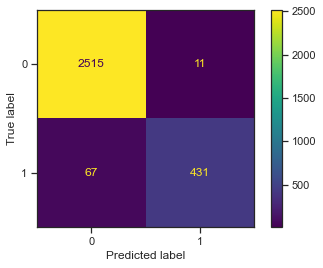

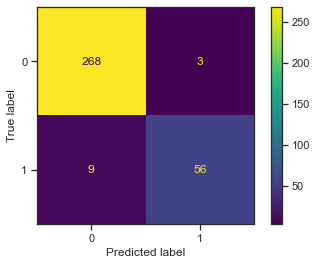

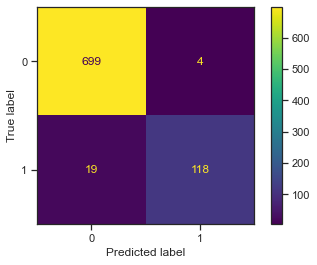

In [93]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

In [94]:
cnn_model.save('cnn_model_Tuberculosis.h5')

**Model Prediction**

In [96]:
img_path = ['../Data/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-18.png','../Data/TB_Chest_Radiography_Database/Normal/Normal-2.png','../Data/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-52.png']

for i in img_path:
    z_img = cv2.imread(i)
    z_img = cv2.resize(z_img, (70, 70)) / 255.0
    z_img = z_img.reshape(1, z_img.shape[0], z_img.shape[1], z_img.shape[2])
    
    z = cnn_model.predict(z_img)
    z = np.argmax(z, axis = 1)
    print("Image", img_path.index(i) + 1, ":", z)



Image 1 : [1]
Image 2 : [0]
Image 3 : [1]
